In [460]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [461]:
plt.style.use('ggplot')

In [599]:
OLCI_WBANDS = np.array([400,412.5,442.5,490,510,560,620,665,673.75,681.25,708.75])
HSI_WBANDS = np.arange(400, 711, 5)
WBANDS = HSI_WBANDS

In [600]:
def interpolate_to_wavebands(data, wavelength, index='wavelength'):
    '''
    interpolates SIOPs to OLCI/MERIS wavebands
    '''
    data.reset_index(inplace=True)
    # add OLCI/MERIS wavebands to phytop SIOP wavelengths
    wband_merge = np.unique(sorted(np.append(data[index], wavelength)))
    
    data.set_index(index, inplace=True)
    data = data.reindex(wband_merge)\
        .astype(float)\
        .interpolate(method='slinear', fill_value=0, limit_direction='both')\
        .reindex(wavelength)
    
    return data

In [601]:
class IOP_model:
    def __init__(self):
        self._wavebands = None
        self.iop_model = None
    
    def set_iop(self, wavebands, **kwargs):
        if self.check_wavelen(wavebands, **kwargs):
            self._wavebands = wavebands
            self.iop_model = {k: v for (k,v) in kwargs.items()}
    
    def get_iop(self, **kwargs):
        iops = []
        for k, value in kwargs.items():
            iops.append([self.iop_model.get(k)(value)[0]()])
        
        iops = np.vstack(iops)
        
        return iops
   
    def get_gradient(self, **kwargs):
        grads = []
        for k, value in kwargs.items():
            grads.append(self.iop_model.get(k)(value)[1]())
        
        grads = np.vstack(grads)
        
        return grads
    
    def sum_iop(self, **kwargs):
        iops = self.get_iop(**kwargs).sum(axis=0)
        
        return iops
    
    def plot(self, **kwargs):
        n = len(kwargs)
        fig, axs = plt.subplots(n)
        # clean-up loop code
        for (k,v), ax in zip(kwargs.items(), axs):
            ax2 = ax.twinx()
            ax.plot(self._wavebands, self.get_iop(**{k:v})[0][0])
            ax.set_xlabel('wavelength')
            ax.set_ylabel('absorption')
            ax.set_title(k)
            ax2.plot(self._wavebands, self.get_iop(**{k:v})[0][1], color='blue')
            ax2.set_ylabel('backscatter')
        plt.tight_layout()
        #return fig
        
    @staticmethod
    def check_wavelen(wavebands, **kwargs):
        models = [i for i in kwargs.values()]
        # check dimensions of models; skip gradients for now
        dims = [i(1)[0]().shape[1] for i in models]
        # check if all dimension match
        if len(set(dims)) != 1:
            raise ValueError('length of IOP vectors do not match')
        elif dims[0] != len(wavebands):
            raise ValueError('number of wavebands do not match with length of IOP vectors')
        
        return True

In [602]:
class Hydropt:
    def __init__(self, iop_model):
        self.iop_model = iop_model
        self.model_coef = None
        self.model_powers = None
        self.set_model_coef()
        
    def set_model_coef(self):
        model_coef = pd.read_csv('../hydropt/data/PACE_polynom_05.csv', index_col = 0)
        # check if wavebands match
        if np.array_equal(model_coef.index, self.iop_model._wavebands):
            self.model_coef = model_coef
            self.model_powers = PolynomialFeatures(degree=5).fit([[1,1]]).powers_
        else:
            raise ValueError('wavebands do not match number of model coefficients')
            
    def hydrolight_polynom(self, x, degree=5):
        '''
        Forward model using polynomial fit to Hydrolight simulations

        x[0]: total absorption at wavelength i
        x[1]: total backscatter at wavelength i

        returns Rrs
        '''
        # log absorption, backscatter
        x_log = np.log(x)
        # get polynomial features
        ft = PolynomialFeatures(degree=degree).fit_transform(x_log.T)
        # get polynomial coefficients
        c = self.model_coef
        # calculate log(Rrs)
        log_rrs = np.dot(c, ft.T).diagonal()
        # calculate Rrs
        rrs = np.exp(log_rrs)

        return rrs
    
    def forward(self, **kwargs):
        # calculate total absorption/backscatter
        iop = self.iop_model.sum_iop(**kwargs)
        
        return self.hydrolight_polynom(iop)

In [603]:
def nap(*args):
    '''
    IOP model for NAP
    '''
    # vectorized
    def iop(spm=args):
        return spm*np.array([(.041*.75*np.exp(-.0123*(WBANDS-443))), .014*0.57*(550/WBANDS)])
    
    def gradient():
        d_a = .03075*np.exp(-.0123*(WBANDS-443))
        d_b = .014*0.57*(550/WBANDS)
        
        return np.array([d_a, d_b])
    
    return iop, gradient

In [604]:
def cdom(*args):
    '''
    IOP model for CDOM
    '''
    def iop(a_440=args):
        return np.array([a_440*np.exp(-0.017*(WBANDS-440)), np.zeros(len(WBANDS))])
    
    def gradient():
        '''
        Gradient of CDOM IOP model
        ''' 
        d_a = np.exp(-.017*(WBANDS-440))
        d_b = np.zeros(len(d_a))
        
        return np.array([d_a, d_b])
    
    return iop, gradient

In [605]:
def phyto(*args):
    '''
    IOP model for phytoplankton w. 
    packaging effect - according to Prieur&Sathyenadrath (1981)
    basis vector - according to Ciotti&Cullen 2002
    '''
    # load phytoplankton basis vector
    a_phyto_base = pd.read_csv('../hydropt/data/phyto_siop.csv', sep=';', index_col=0)
    # interpolate to OLCI wavebands
    a_phyto_base = interpolate_to_wavebands(data=a_phyto_base, wavelength=WBANDS)
    # remove negative absorption values and set to 0
    #a_phyto_base.loc[708.75] = 0
    
    def iop(chl=args):
        # calculate absorption
        a = 0.06*np.power(chl,.65)*a_phyto_base.absorption.values
        # calculate backscatter according to 0.1-tadzio-IOP_backscatter
        # notebook in hydropt-4-sent3
        b = np.repeat(.014*0.18*np.power(chl,.471), len(a))
        
        return np.array([a, b])
    
    def gradient():
        return None
    
    return iop, gradient

In [590]:
class ThreeCompModel(IOP_model):
    def __init__(self):
        self._wavebands = OLCI_WBANDS
        self.iop_model = {'nap': nap,
                          'cdom': cdom,
                          'phyto': phyto}

In [606]:
a = IOP_model()
a.set_iop(WBANDS, nap=nap, cdom=cdom, phyto=phyto)

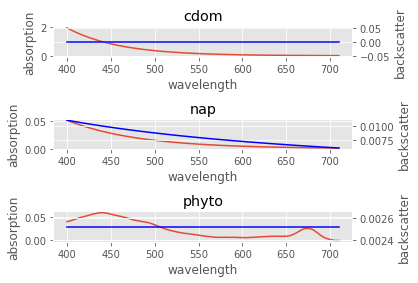

In [608]:
a.plot(cdom=1, nap=1, phyto=1)

In [609]:
ps1 = Hydropt(a)

## to do:
change scatter model IOPs to backscatter model for PACE polynomial. 